In [ ]:
import nltk
nltk.download('all')

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from scipy import stats
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt
import string
import re
import emoji
import random
from nltk.corpus import stopwords
from pattern.text.en import singularize, lemma
from wordcloud import WordCloud
from transformers import BertTokenizer,BertModel, AdamW, get_linear_schedule_with_warmup
import tensorflow
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import plot_model

In [30]:
# Cargando datos
train = pd.read_csv('./train.csv', encoding='utf8')
test = pd.read_csv('./test.csv', encoding='utf8')

stopWords = stopwords.words('english')

<AxesSubplot:>

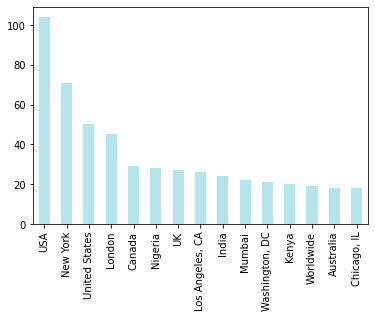

In [15]:
train['location'].value_counts().head(15).plot.bar(color="#B3E5EB")

<AxesSubplot:>

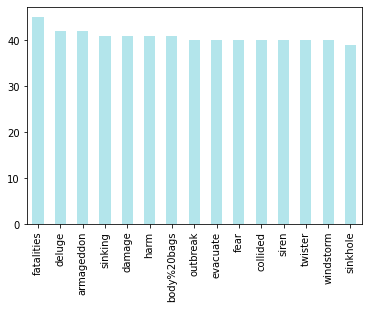

In [14]:
train['keyword'].value_counts().head(15).plot.bar(color="#B3E5EB")

<AxesSubplot:>

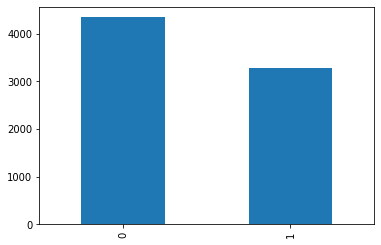

In [12]:
train['target'].value_counts().plot.bar()

In [18]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

<AxesSubplot:>

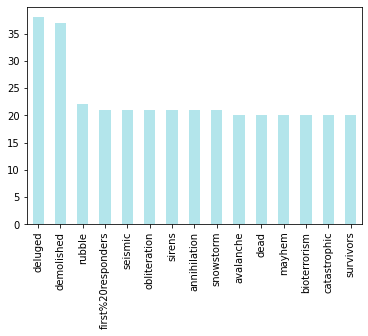

In [10]:
test['location'].value_counts().head(15).plot.bar(color="#B3E5EB")

<AxesSubplot:>

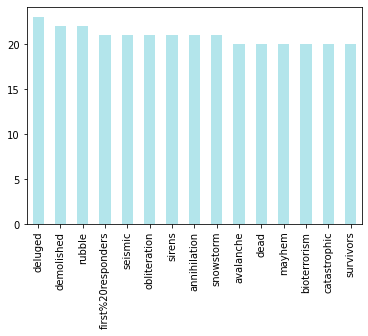

In [16]:
test['keyword'].value_counts().head(15).plot.bar(color="#B3E5EB")

Limpieza de Datos

In [31]:
for i in range(len(train)):
    train.loc[i,'text'] = train.loc[i,'text'].lower()

for i in range(len(test)):
    test.loc[i,'text'] = test.loc[i,'text'].lower()

In [20]:
#Quitar las urls
for i in range(len(train)):
    train.loc[i,'text'] = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', "", train.loc[i,'text'])

for i in range(len(test)):
    test.loc[i,'text'] = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', test.loc[i,'text'])


In [50]:
#Se eliminan los signos de puntuacion
for i in range(len(train)):
    train.loc[i,'text'] = train.loc[i,'text'].translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    

for i in range(len(test)):
    test.loc[i,'text'] = test.loc[i,'text'].translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))

In [52]:
#Ref: https://www.delftstack.com/howto/python/remove-stop-words-in-python/#:~:text=The%20nlkt%20(Natural%20Language%20Processing,the%20list%20from%20this%20library.
#Quitar las stopwords
stopWords = stopwords.words('english')

for i in range(len(train)):
    train.loc[i,'text'] = ' '.join(word for word in train.loc[i,'text'].split() if word not in stopWords)

for i in range(len(test)):
    test.loc[i,'text'] = ' '.join(word for word in test.loc[i,'text'].split() if word not in stopWords)

TypeError: first maketrans argument must be a string if there is a second argument

In [25]:
#Ref: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
# Se eliminan emojis
emoj = re.compile("["
                         u"\U0001F600-\U0001F64F"  # emoticons
                         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                         u"\U0001F680-\U0001F6FF"  # transport & map symbols
                         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                         u"\U00002500-\U00002BEF"  # chinese char
                         u"\U00002702-\U000027B0"
                         u"\U00002702-\U000027B0"
                         u"\U000024C2-\U0001F251"
                         u"\U0001f926-\U0001f937"
                         u"\U00010000-\U0010ffff"
                         u"\u2640-\u2642"
                         u"\u2600-\u2B55"
                         u"\u200d"
                         u"\u23cf"
                         u"\u23e9"
                         u"\u231a"
                         u"\ufe0f"  # dingbats
                         u"\u3030"
                         "]+", flags=re.UNICODE)

for i in range(len(train)):
    train.loc[i, 'text'] = emoj.sub(r'', train.loc[i, 'text'])

for i in range(len(test)):
    test.loc[i, 'text'] = emoj.sub(r'', test.loc[i, 'text'])


In [27]:
#Quitar numeros, se considera dejar el 911 ya que es un numero representativo en EEUU y puede ser de utilidad
for i in range(len(train)):
    train.loc[i,'text'] = re.sub(r'#\S+|\d+', lambda match: match.group(0) if match.group(0).startswith('911') else '', train.loc[i,'text'])

for i in range(len(test)):
    test.loc[i,'text'] = re.sub(r'#\S+|\d+', lambda match: match.group(0) if match.group(0).startswith('911') else '', test.loc[i,'text'])